# Sentiment analysis
This notebook contains step by step experiments with SLM sentiment analysis.

## Dataset
First lets download the dataset and explore it

In [1]:
from datasets import load_dataset, concatenate_datasets

ds = load_dataset("ajaykarthick/imdb-movie-reviews")

/Users/kosst/src/sentiment/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

For start, I pick first 100 examples from the dataset. It should be enough for stable evaluation and will speed up development.

I checked that subset is perfectly ballanced. I don't care about shuffling because for eval it doesn't metter.

In [3]:
positive_ds = ds["train"].select(range(200)).filter(lambda example: example['label'] == 0).select(range(50))
negative_ds = ds["train"].select(range(200)).filter(lambda example: example['label'] == 1).select(range(50))
subset = concatenate_datasets([positive_ds, negative_ds])

In [4]:
len(subset), sum(subset["label"])

(100, 50)

For final evaluation let's prepare bigger dataset. I take different examples for better robustness.

In [5]:
positive_ds = ds["train"].select(range(1000, 2000)).filter(lambda example: example['label'] == 0).select(range(250))
negative_ds = ds["train"].select(range(1000, 2000)).filter(lambda example: example['label'] == 1).select(range(250))
subset_500 = concatenate_datasets([positive_ds, negative_ds])
len(subset_500), sum(subset_500["label"])

(500, 250)

In [6]:
from sentiment import evaluation

## Metrics
Now it's time to think about metrics.
Luckly we have ballanced dataset, so accuracy will be the main metric.
However, we need more information to understand model behavior.

Here we include errors both as false positive and false negative to see the effect of errors.

In [31]:
def accuracy(statistics):
    return (statistics["tp"] + statistics["tn"]) / (statistics["tp"] + statistics["tn"] + statistics["fp"] + statistics["fn"] + statistics["error"])
accuracy({'tp': 44, 'tn': 50, 'fp': 0, 'fn': 6, 'error': 0})

0.94

In [33]:
def precision(statistics):
    return statistics["tp"] / (statistics["tp"] + statistics["fp"] + statistics["error"])
def recall(statistics):
    return statistics["tp"] / (statistics["tp"] + statistics["fn"] + statistics["error"])
precision({'tp': 44, 'tn': 50, 'fp': 0, 'fn': 6, 'error': 0}), recall({'tp': 44, 'tn': 50, 'fp': 0, 'fn': 6, 'error': 0})

(1.0, 0.88)

## First version of template
No few-shot examples or special instructions.

In [7]:
template = """<|im_start|>system
You are a sentiment classifier. You carefully analyse the movie review and classify it as negative "1" or positive "0".<|im_end|>
<|im_start|>user
Return only one symbol:
0 - for positive review
1 - for negative review

Review:
{{ review }}<|im_end|>
<|im_start|>assistant
"""

In [10]:
config = {
    "temperature": 0, # For reproducibility we use greedy decoding
    "top_k": 1, # For greedy decoding
    "max_tokens": 5
}


In [11]:
# 0.5B
evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template, subset, config)

{'tp': 16,
 'tn': 2,
 'fp': 48,
 'fn': 34,
 'error': 0,
 'accuracy': 0.18,
 'precision': 0.25,
 'recall': 0.32}

In [12]:
# 1.5B
evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template, subset, config)

{'tp': 49,
 'tn': 46,
 'fp': 4,
 'fn': 1,
 'error': 0,
 'accuracy': 0.95,
 'precision': 0.9245283018867925,
 'recall': 0.98}

**Results:**

Good:
 - we don't have any parsing errors, which is great.
 - 1.5B shows really good results.

Bad:
 - 0.5B shows performance worse than random. 

## Reasoninig prompt
In order to debug what is a problem with 0.5B we add reasoning into the propmt

In [8]:
template_reason = """<|im_start|>system
You are a sentiment classifier. You carefully analyse the movie review and classify it as negative "1" or positive "0".<|im_end|>
<|im_start|>user
# Output format:
Return JSON with schema:
{
  "reasoning": str, # Short explanation why this review can be classified as positive or negative. 
  "label": int # 0 - positive, 1 - negative
}

# Review text:
{{ review }}<|im_end|>
<|im_start|>assistant
# Output:
"""

In [14]:
config = {
    "temperature": 0, # For reproducibility
    "top_k": 1,
    "max_tokens": 200
}

In [15]:
# 0.5B
evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_reason, subset, config, parse="json")

Incorrect json < 
{
  "reasoning": "The review criticizes the movie for its portrayal of a young girl's struggle with a debilitating condition, suggesting that the portrayal is overly simplistic and inaccurate. The reviewer also expresses disappointment with the film's treatment of the social alienation of individuals with mental health issues. The review concludes by calling the movie "an excellent film made with extreme sensitivity to the subject. HATS OFF to Ms Sen! No one in India could've done it better.",
  "label": 1
}>
Incorrect json < 
{
  "reasoning": "The review expresses strong negative sentiment, criticizing the movie for being "unpretty" and "not fitting the child's expectations. " It also mentions the reviewer's disappointment and frustration with the movie's portrayal of the NFL and football teams.",
  "label": 1
}>
Incorrect json < 
{
  "reasoning": "The review criticizes the film for being a "very good action comedy film" but also for being "blasted by most critics" a

{'tp': 7,
 'tn': 17,
 'fp': 25,
 'fn': 36,
 'error': 15,
 'accuracy': 0.24,
 'precision': 0.14893617021276595,
 'recall': 0.1206896551724138}

Looks like model has problems with labels itself, not the understanding.
Reasoning is correct, but lael is wrong. Indeed, negative examples are makred as 0 more often.

Model has issues with json formatting, so there is no reason to use it further.

## Word labeling template
Instead of confusing 0 and 1 will use POSITIVE and NEGATIVE labels.

In addition we improve prompt formatting a little bit.

In [9]:
template_label = """<|im_start|>system
You are a sentiment classifier. You carefully analyse the movie review and classify it as POSITIVE or NEGATIVE.<|im_end|>
<|im_start|>user
# Output format:
Only one word expected - 'POSITIVE' or 'NEGATIVE'
No quotes in the output.

# Review text:
{{ review }}<|im_end|>
<|im_start|>assistant
# Output:
"""

In [17]:
config = {
    "temperature": 0, # For reproducibility
    "top_k": 1,
    "max_tokens": 20
}

In [18]:
# 0.5B
evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_label, subset, config, parse="label")

{'tp': 44,
 'tn': 50,
 'fp': 0,
 'fn': 6,
 'error': 0,
 'accuracy': 0.94,
 'precision': 1.0,
 'recall': 0.88}

In [19]:
# 1.5B
evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_label, subset, config, parse="label")

{'tp': 48,
 'tn': 49,
 'fp': 1,
 'fn': 2,
 'error': 0,
 'accuracy': 0.97,
 'precision': 0.9795918367346939,
 'recall': 0.96}

## Word label with no system
We get good results but now we should check other prompt options.

In [10]:
template_label_no_system = """<|im_start|>user
You are a sentiment classifier. You carefully analyse the movie review and classify it as POSITIVE or NEGATIVE.

# Output format:
Only one word expected - 'POSITIVE' or 'NEGATIVE'
No quotes in the output.

# Review text:
{{ review }}<|im_end|>
<|im_start|>assistant
# Output:
"""

In [21]:
res_small_no_sys_05 = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_label_no_system, subset, config, parse="label")
res_small_no_sys_15 = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_label_no_system, subset, config, parse="label")
res_small_no_sys_05, res_small_no_sys_15

({'tp': 44,
  'tn': 50,
  'fp': 0,
  'fn': 6,
  'error': 0,
  'accuracy': 0.94,
  'precision': 1.0,
  'recall': 0.88},
 {'tp': 48,
  'tn': 49,
  'fp': 1,
  'fn': 2,
  'error': 0,
  'accuracy': 0.97,
  'precision': 0.9795918367346939,
  'recall': 0.96})

Looks like system message doesn't have significant impact.

## Word label + reasoning
Let's try to combine all techniques together

In [11]:
template_label_reason = """<|im_start|>system
You are a sentiment classifier. You carefully analyse the movie review and classify it as POSITIVE or NEGATIVE.<|im_end|>
<|im_start|>user
# Output format:
Two lines of text.
First line is a short reasoning about review sentiment, pointing out the most important expressions for sentiment classification. Starts with "Reasonoing: ".
Second line is a final label. Starts with "Label: ". Only POSITIVE or NEGATIVE labels allowed.

# Examples:
## Example 1:
Review text:
This movie is not the great one, but I like it.

Output:
Reasoning: From one hand "is not the great one" is negative sentiment. On another hand "i like it" is positive. Overall sentiment is more positive.
Label: POSITIVE

## Example 2:
Review text:
The cast is great and my expectations were huge. But director is great in ruining the movie which was impossible to ruin.

Output:
Reasoning: From one hand "cast is great" is positive sentiment. On another hand "director is great in ruining" is negative. Overall sentiment is more negative.
Label: NEGATIVE

# Review text:
{{ review }}<|im_end|>
<|im_start|>assistant
# Output:
"""

In [12]:
config_reason = {
    "temperature": 0, # For reproducibility
    "top_k": 1,
    "max_tokens": 200
}
res_small_label_reason_05 = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_label_reason, subset, config_reason, parse="lines")
res_small_label_reason_15 = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_label_reason, subset, config_reason, parse="lines")
res_small_label_reason_05, res_small_label_reason_15

Incorrect output <  
Reasoning: The reviewer expresses a positive sentiment towards the film, highlighting its suspenseful plot, effective direction, and memorable performances. The final label is POSITIVE.>
Incorrect output <  
Reasoning: The movie is described as a "thrill on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface" and "thrills on the surface>
Incorrect output <  
Reasoning: The revie

({'tp': 42,
  'tn': 43,
  'fp': 5,
  'fn': 6,
  'error': 4,
  'accuracy': 0.85,
  'precision': 0.8235294117647058,
  'recall': 0.8076923076923077},
 {'tp': 49,
  'tn': 49,
  'fp': 1,
  'fn': 1,
  'error': 0,
  'accuracy': 0.98,
  'precision': 0.98,
  'recall': 0.98})

Interesting. 
- We can see small improvement for 1.5B and decrease for 0.5B.
- Additionally 0.5B can't handle this output format. Errors appear.
- Looks like 0.5B consider this as overcomplication.
- Good candidate for 1.5B if we don't care about latency.

## Compare on big dataset
In order to have more reliable numbers we evaluate final result on large dataset.

In [13]:
%%time
# WARNING: Takes a lot of time!

res_05_init = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template, subset_500, config, parse="int")
print(res_05_init)
res_15_init = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template, subset_500, config, parse="int")
print(res_15_init)
res_05_label = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_label, subset_500, config, parse="label")
print(res_05_label)
res_15_label = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_label, subset_500, config, parse="label")
print(res_15_label)
config = {
    "temperature": 0, # For reproducibility
    "top_k": 1,
    "max_tokens": 200
}
res_05_reason = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_reason, subset_500, config_reason, parse="json")
print(res_05_reason)
res_15_reason = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_reason, subset_500, config_reason, parse="json")
print(res_15_reason)

{'tp': 97, 'tn': 7, 'fp': 243, 'fn': 153, 'error': 0, 'accuracy': 0.208, 'precision': 0.2852941176470588, 'recall': 0.388}
{'tp': 238, 'tn': 218, 'fp': 32, 'fn': 12, 'error': 0, 'accuracy': 0.912, 'precision': 0.8814814814814815, 'recall': 0.952}
{'tp': 221, 'tn': 233, 'fp': 17, 'fn': 29, 'error': 0, 'accuracy': 0.908, 'precision': 0.9285714285714286, 'recall': 0.884}
{'tp': 236, 'tn': 237, 'fp': 13, 'fn': 14, 'error': 0, 'accuracy': 0.946, 'precision': 0.9477911646586346, 'recall': 0.944}
Incorrect json < 
{
  "reasoning": "The review criticizes the film for its lack of depth and complexity, focusing on the lack of a strong narrative and the use of visual storytelling. It also mentions the lack of a strong lead actress and the use of long title cards. The reviewer also notes that the film is not a comedy and that the only dramatic performance is in "Male and Female".",
  "label": 0
}>
Incorrect json < 
{
  "reasoning": "The review criticizes the movie for its lack of depth, poor actin

KeyError: 'line'

In [14]:
res_05_label_reason = evaluation.evaluate("./models/Qwen2.5-0.5B-Instruct-Q5_K_M.gguf", template_label_reason, subset_500, config_reason, parse="lines")
print(res_05_label_reason)
res_15_label_reason = evaluation.evaluate("./models/Qwen2.5-1.5B-Instruct-Q5_K_M.gguf", template_label_reason, subset_500, config_reason, parse="lines")
print(res_15_label_reason) 

Incorrect output <  
Reasoning: George C. Scott is the most positive actor, Paddy Chayefsky is the most positive director, Diana Rigg is the most positive actress, Barnard Hughes is the most positive stage actor, George C. Scott is the most positive writer, Paddy Chayefsky is the most positive director, Vanessa Redgrave is the most positive actress, Barnard Hughes is the most positive stage actor, George C. Scott is the most positive nominated actor, Paddy Chayefsky is the most positive nominated director, Vanessa Redgrave is the most positive nominated actress, Barnard Hughes is the most positive nominated stage actor, George C. Scott is the most positive nominated writer, Paddy Chayefsky is the most positive nominated director, Vanessa Redgrave is the most positive nominated actress, Barnard Hughes is the most positive nominated stage actor, George C. Scott is the most positive nominated writer, Paddy Chayefsky is the most positive nominated director,>
Incorrect output <  
Reasoning:

## Visualisation
Finally we want to see performance increase during our iterations. We will compare accuracies.

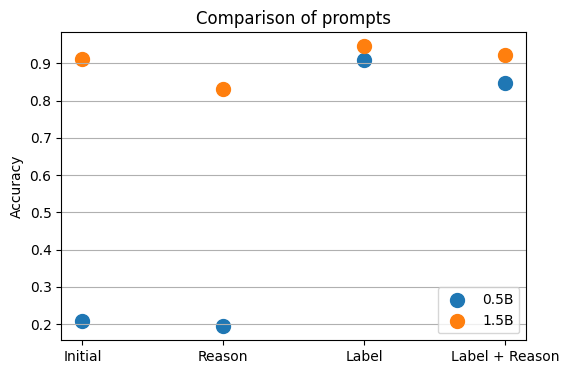

In [30]:
import matplotlib.pyplot as plt

categories = ['Initial', 'Reason', 'Label', 'Label + Reason']
values_05 = [res_05_init, res_05_reason, res_05_label, res_05_label_reason]
values_15 = [res_15_init, res_15_reason, res_15_label, res_15_label_reason]
values_05 = [val["accuracy"] for val in values_05]
values_15 = [val["accuracy"] for val in values_15]

plt.figure(figsize=(6, 4))
plt.scatter(categories, values_05, s=100, label="0.5B")
plt.scatter(categories, values_15, s=100, label="1.5B")

plt.grid(True, which='both', axis="y")
    
plt.title('Comparison of prompts')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Conclusion:
- Prompt engineering helped to dramatically increase quality of 0.5B model, but still quality of 1.5B is better, which is expected.
- 0.5B with label prompt is close to 1.5 with initial prompt.
- Reasoning helpes to debug some problems, but doesn't improve quality for both models.
- 0.5B shows disballance with small recall, which means it often labels positive reviews as negative.
- In future work we can use this information to build good DPO dataset to improve performance in this case.